# Method 1: Using Pystan

I'll do this for a single n, and treat the mode locations as fixed for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import corner
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)


#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
dnu = 102. #uHz

In [2]:
locs = np.genfromtxt('locs.txt')
l0 = locs[int(np.floor(len(locs)/2)), 0]
l1 = locs[int(np.floor(len(locs)/2)), 1]
l2 = locs[int(np.floor(len(locs)/2)-1), 2]
l3 = locs[int(np.floor(len(locs)/2)-1), 3]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [3]:
sel = [(ff >= l0 - 0.3*dnu) & (ff <= l0 + 0.7*dnu)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


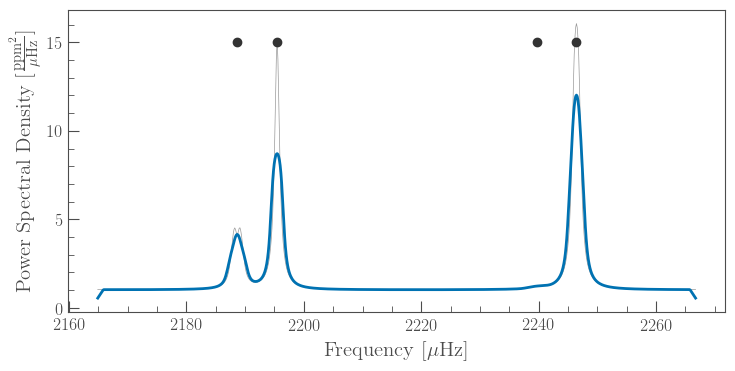

In [4]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter([l0,l1,l2,l3],[15,15,15,15])

Lets fit a group of lorentzians to these data!

In [6]:
import pystan
model = '''
functions{
    real lorentzian(real loc, int l, int m, real f, real H, real w, real nus){
        return H ./ (1 + (4/w^2) * (f - loc + m*nus)^2);
    }

    real[] multiplets(int N, real[] locs, real[] f, real[] H, real[] w, real nus){
        real mod[N]; 
        mod = rep_array(1., N);   // Give the model a fixed background of 1.
        
        for (l in 0:3){           // Iterate over all l in a given n
            for (m in -l:l){      // Iterate over all m in a given l
                for (n in 1:N){   // Generate the value of a lorentzian for this l and m at a given f
                    mod[n] += lorentzian(locs[l+1], l, m, f[n], H[l+1], w[l+1], nus);
                }
            }
        }
        return mod;
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    real f[N];        // Frequency
    real p[N];        // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
}
parameters{
    real logAmp[M];      // Mode amplitude in log space
    real logGamma[M];    // Mode linewidth in log space
    real locs[M];        // True mode locations
    real<lower=0> nus;   // Rotational frequency splitting
}
transformed parameters{
    real H[M];   // Mode height
    real w[M];   // Mode linewidth
     
    for (m in 1:M){
        w[m] = 10^logGamma[m];                 // Transform mode linewidth from log space
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    real modes[N];

    modes = multiplets(N, locs, f, H, w, nus);
    modes ~ normal(p, 0.1);  // This will eventually have to be expanded to deal with Chi^2dof noise
    
    //priors on the parameters
    logAmp ~ normal(1, 1);
    logGamma ~ normal(0, 0.1);
    locs ~ normal(asy_locs, 1);
    nus ~ normal(0.411, 0.1);
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b9376472cdff1de46a73425dea9d5c26 NOW.


In [7]:
data = {'N':len(f),
        'M': 4,
        'f':f,
        'p':p,
        'asy_locs':[l0,l1,l2,l3]}

init = {'logAmp' : np.ones(4),
        'logGamma' : np.zeros(4),
        'nus':nus,
        'locs' : [l0, l1, l2, l3]}

In [8]:
nchains = 4
fit = sm.sampling(data=data, iter=500, chains=nchains, init = [init for n in range(nchains)])

In [9]:
print(fit)

Inference for Stan model: anon_model_b9376472cdff1de46a73425dea9d5c26.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]     1.64  6.2e-5 1.8e-3   1.64   1.64   1.64   1.65   1.65    858    1.0
logAmp[2]     1.34  4.4e-5 1.5e-3   1.34   1.34   1.34   1.34   1.34   1124    1.0
logAmp[3]      0.6  1.7e-4 5.2e-3   0.59    0.6    0.6    0.6   0.61    961    1.0
logAmp[4]    -0.95  3.7e-3    0.1  -1.17  -1.01  -0.95  -0.88  -0.78    713    1.0
logGamma[1] 6.6e-4  8.4e-5 2.6e-3-4.5e-3-1.1e-3 7.3e-4 2.5e-3 5.6e-3    935    1.0
logGamma[2]-3.5e-3  1.2e-4 3.8e-3  -0.01-6.1e-3-3.4e-3-9.3e-4 3.6e-3   1057    1.0
logGamma[3]  -0.02  5.4e-4   0.02  -0.05  -0.03  -0.02-6.7e-3 9.7e-3    792    1.0
logGamma[4]   0.01  3.5e-3    0.1  -0.19  -0.05   0.01   0.08   0.19    769   1.01
locs[1]     2195.4  5.5e-5 2.0e-3 2195.4 2195.4 2195.4 2195.4 2195.

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


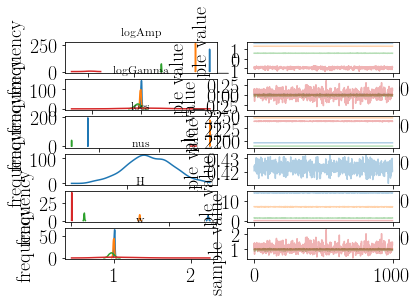

In [10]:
fit.plot()
plt.show()

In [12]:
truths= [np.nan, np.nan,init['nus']]

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


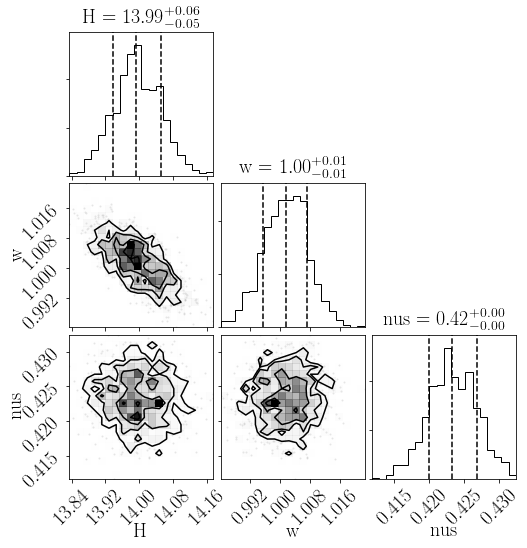

In [15]:
labels=['H','w','nus']
chain = np.array([fit[labels[0]].T[0], fit[labels[1]].T[0], fit[labels[2]]])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True,title_kwargs={"fontsize": 20})
plt.show()

# Now lets overplot the best fit model

In [35]:
def lorentzian(f, m, loc, H, w, nus):
    model = H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
for l in np.arange(3+1):
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[l])
        H = np.median(fit['H'].T[l])
        w = np.median(fit['w'].T[l])
        nus = np.median(fit['nus'])
        model += lorentzian(f, m, loc, H, w, nus)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


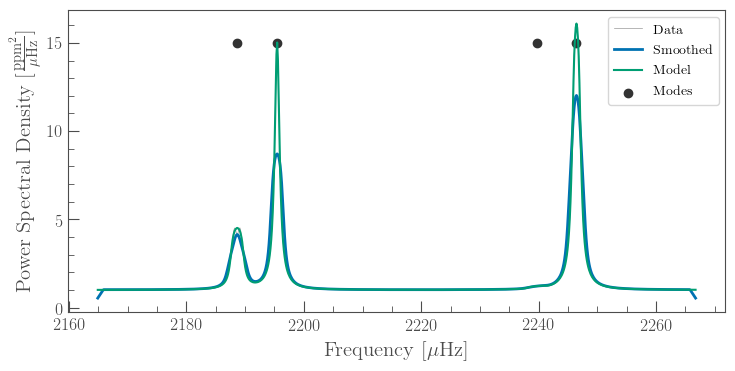

In [39]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data')
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2, label='Smoothed')
plt.scatter([l0,l1,l2,l3],[15,15,15,15], label='Modes')
plt.plot(f, model, label='Model')
plt.legend()